<a href="https://colab.research.google.com/github/dsklnr/ADS_509_Module3/blob/main/Group%20Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADS 509 Module 3: Group Comparison

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics for the two artists you selected in Module 1 and the Twitter descriptions pulled for Robyn and Cher. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following:

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set.
* Calculate descriptive statistics on the two sets of lyrics and compare the results.
* For each of the four corpora, find the words that are unique to that corpus.
* Build word clouds for all four corpora.

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization).


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*


In [3]:
!pip install emoji

In [4]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [5]:
# Use this space for any additional import statements you need
import nltk
nltk.download('stopwords')
from string import punctuation
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
# Place any addtional functions or constants you need here.

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA :
    for em in emoji.EMOJI_DATA[country] :
        all_language_emojis.add(em)

def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    token_limit = 5
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / num_tokens if num_tokens != 0 else 0.0
    num_characters = sum(len(token) for token in tokens)

    if verbose :
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")

        # print the five most common tokens
        most_common_tokens = Counter(tokens).most_common(token_limit)
        print(f"\nThe {token_limit} most common tokens are:")
        for token, freq in most_common_tokens:
            print(f"'{token}' appears {freq} time(s)")

    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])



def contains_emoji(s):

    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    return(tokens)

def remove_punctuation(text, punct_set=tw_punct) :
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) :
    # Tokenize by splitting on whitespace
    tokens = text.split()

    # modify this function to return tokens
    return(tokens)

def prepare(text, pipeline) :
    tokens = str(text)

    for transform in pipeline :
        tokens = transform(tokens)

    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [7]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Define paths
data_location = '/content/drive/My Drive/ADS 509/M1 Results/'
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

# Define paths for the lyrics and twitter folders
lyrics_path = os.path.join(data_location, lyrics_folder)
twitter_path = os.path.join(data_location, twitter_folder)
os.listdir(twitter_path)

['.DS_Store',
 'cher_followers_data.txt',
 'robynkonichiwa_followers.txt',
 'robynkonichiwa_followers_data.txt',
 'cher_followers.txt',
 'cher_followers.csv',
 'robynkonichiwa_followers.csv']

In [10]:
# Read in the lyrics data

# Function to load all lyric files for an artist
def load_lyrics(artist_folder):
    lyrics_data = []

    artist_path = os.path.join(lyrics_path, artist_folder)

    # Iterate through all the files in the artist's lyrics folder
    for filename in os.listdir(artist_path):
        if filename.endswith(".txt"):  # Assuming lyrics files are .txt
            with open(os.path.join(artist_path, filename), 'r', encoding='utf-8') as file:
                lyrics = file.read()
                # Assuming the song title is the filename (without extension)
                song = os.path.splitext(filename)[0]
                lyrics_data.append({"song": song, "lyrics": lyrics})

    # Convert to DataFrame
    return pd.DataFrame(lyrics_data)

In [11]:
# Function to convert all '_data.txt' files to .csv
def convert_txt_to_csv():
    files = os.listdir(twitter_path)

    # Iterate through all files and pick those ending with '_data.txt'
    for filename in files:
        if filename.endswith("_data.txt"):
            file_path = os.path.join(twitter_path, filename)

            try:
                # Read the txt file into a DataFrame (assuming tab-separated)
                df = pd.read_csv(file_path, delimiter="\t", on_bad_lines='skip')

                # Define the new CSV file path
                csv_filename = filename.replace("_data.txt", ".csv")
                csv_file_path = os.path.join(twitter_path, csv_filename)

                # Save the DataFrame as a CSV file
                df.to_csv(csv_file_path, index=False)
                print(f"Converted {filename} to {csv_filename}")

            except pd.errors.ParserError as e:
                print(f"Error parsing {filename}: {e}")

convert_txt_to_csv()

Converted cher_followers_data.txt to cher_followers.csv
Converted robynkonichiwa_followers_data.txt to robynkonichiwa_followers.csv


In [12]:
# Function to load Twitter data (only _data.txt files) for an artist
def load_twitter(artist_name):
    twitter_df = pd.DataFrame()

    # Iterate through all files in the twitter folder
    for filename in os.listdir(twitter_path):
        if filename.startswith(artist_name) and filename.endswith(".csv"):
            print(filename)
            file_path = os.path.join(twitter_path, filename)

            # Read the CSV file and select the 'description' column
            df = pd.read_csv(file_path)

            # Append the data to the artist's twitter DataFrame
            twitter_df = pd.concat([twitter_df, df], ignore_index=True)
    return twitter_df

load_twitter(twitter_folder)

""


In [13]:
# List of artist folders
artist_folders = ["cher", "robyn"]

# Dictionary to hold dataframes for each artist
artist_lyrics_dfs = {}
artist_twitter_dfs = {}

# Loop through each artist and store their lyrics in DataFrames
for artist in artist_folders:
    artist_lyrics_df = load_lyrics(artist)
    artist_lyrics_dfs[artist] = artist_lyrics_df

    # Load twitter data for the artist
    artist_twitter_df = load_twitter(artist)
    artist_twitter_dfs[artist] = artist_twitter_df

cher_followers.csv
robynkonichiwa_followers.csv


In [14]:
artist_lyrics_dfs["cher"].head()

,song,lyrics
0,cher_thetwelfthofnever,"""The Twelfth Of Never""\n\n\n\nYou ask how much..."
1,cher_olmanriver,"""Ol' Man River""\n\n\n\nHere we all work 'long ..."
2,cher_ayounggirluneenfante,"""A Young Girl (Une Enfante)""\n\n\n\nShe left h..."
3,cher_dontthinktwice,"""Don't Think Twice""\n\n\n\nIt ain't no use to ..."
4,cher_comeandstaywithme,"""Come And Stay With Me""\n\n\n\nI'll send away ..."


In [15]:
artist_twitter_dfs["cher"].head()

,screen_name,name,id,location,followers_count,friends_count,description
0,hsmcnp,Country Girl,3.515221e+07,NaN,1302.0,1014.0,NaN
1,horrormomy,Jeny,7.421531e+17,Earth,81.0,514.0,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜
2,anju79990584,anju,1.496463e+18,NaN,13.0,140.0,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡
3,gallionjenna,J,3.366480e+09,NaN,752.0,556.0,csu
4,bcscomm,bcscomm,8.391504e+07,"Washington, DC",888.0,2891.0,Writer @Washinformer @SpelmanCollege alumna #D...


In [16]:
artist_lyrics_dfs["robyn"].head()

,song,lyrics
0,robyn_shouldhaveknown,"""Should Have Known""\n\n\n\nI should have seen ..."
1,robyn_sayit,"""Sayit""\n\n\n\nSay it\n\nSay say say...\n\nSay..."
2,robyn_underneaththeheart,"""Underneath The Heart""\n\n\n\nI look into your..."
3,robyn_longgone,"""Long Gone""\n\n\n\nLong gone\n\nLips move, I c..."
4,robyn_loveisfree,"""Love Is Free""\n\n\n\nFree\nLove is free, baby..."


In [17]:
artist_twitter_dfs["robyn"].head()

,screen_name,name,id,location,followers_count,friends_count,description
0,AngelxoArts,Angelxo,1424055675030806529,"Zacatlan, Puebla, Mexico",29,535,I love chill •Facebook / Instagram / SoundClou...
1,songsfornikola,johnny,1502717352575651840,NaN,6,318,"books, movies, music, nature & TV shows. OG Sw..."
2,thibaud_lola,Thibaud Lola,1502407708246478852,NaN,3,69,(Am)auteur en herbe 🌱 - juriste en paille 🤡 - ...
3,KyleSew2112,Kyle S 🌹🇬🇧🇺🇦,3423966821,South East London,1258,3444,This Twitter profile is full of sarcasm and ra...
4,MusiFlo,MusiFlo,3324069364,Canada,470,1706,Flora Youssef - Blogger & Founder Posting revi...


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning.

**Lyrics**

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions**

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those.

In [18]:
# Punctuation set excluding periods (.) to preserve abbreviations like L.A.
punctuation = set(string.punctuation) - {'.'}
extra_chars_to_remove = {'•'}

def clean_and_tokenize(text):
    # Remove HTTP and HTTPS links
    text = re.sub(r'http[s]?://\S+', '', text)

    # Remove .co domains
    text = re.sub(r'\b\w+\.co\b', '', text)

    # Replace escape characters like \n, \b, \r, etc. with space
    text = re.sub(r'[\n\r\t\b\f]', ' ', text)

    # Replace unwanted punctuation (except for hashtags) and the • character with space
    text = ''.join([char if char not in punctuation and char not in extra_chars_to_remove else ' ' for char in text])

    # Convert text to lowercase
    text = text.lower()

    # Tokenize by splitting on whitespace
    tokens = text.split()

    # Remove unwanted tokens such as 'null', 'nan'
    unwanted_tokens = {'null', 'nan'}
    tokens = [word for word in tokens if word not in sw and word not in unwanted_tokens]

    return tokens

In [19]:
# create your clean twitter data here
def process_twitter_data(df):
    # Create a new column 'cleaned_description' to store the cleaned tokens
    df['cleaned_description'] = df['description'].apply(lambda x: clean_and_tokenize(str(x)))
    return df

In [20]:
# create your clean lyrics data here
def process_lyrics_data(df):
    # Assuming the lyrics are in a column 'lyrics'
    df['cleaned_lyrics'] = df['lyrics'].apply(lambda x: clean_and_tokenize(str(x)))
    return df

In [21]:
# Process and clean the Twitter data for each artist
for artist in artist_folders:
    artist_twitter_dfs[artist] = process_twitter_data(artist_twitter_dfs[artist])
    artist_lyrics_dfs[artist] = process_lyrics_data(artist_lyrics_dfs[artist])

In [22]:
artist_lyrics_dfs['cher'][['lyrics', 'cleaned_lyrics']].head()

,lyrics,cleaned_lyrics
0,"""The Twelfth Of Never""\n\n\n\nYou ask how much...","[twelfth, never, ask, much, needed, must, expl..."
1,"""Ol' Man River""\n\n\n\nHere we all work 'long ...","[ol, man, river, work, long, mississippi, work..."
2,"""A Young Girl (Une Enfante)""\n\n\n\nShe left h...","[young, girl, une, enfante, left, neighborhood..."
3,"""Don't Think Twice""\n\n\n\nIt ain't no use to ...","[think, twice, use, sit, wonder, baby, n, know..."
4,"""Come And Stay With Me""\n\n\n\nI'll send away ...","[come, stay, send, away, false, pride, forsake..."


In [23]:
artist_lyrics_dfs['robyn'][['lyrics', 'cleaned_lyrics']].head()

,lyrics,cleaned_lyrics
0,"""Should Have Known""\n\n\n\nI should have seen ...","[known, seen, coming, fucking, known, could, l..."
1,"""Sayit""\n\n\n\nSay it\n\nSay say say...\n\nSay...","[sayit, say, say, say, say..., say, say, say, ..."
2,"""Underneath The Heart""\n\n\n\nI look into your...","[underneath, heart, look, eyes, see, place, dr..."
3,"""Long Gone""\n\n\n\nLong gone\n\nLips move, I c...","[long, gone, long, gone, lips, move, hear, sin..."
4,"""Love Is Free""\n\n\n\nFree\nLove is free, baby...","[love, free, free, love, free, baby, free, lov..."


In [24]:
artist_twitter_dfs['cher'][['description', 'cleaned_description']].head()

,description,cleaned_description
0,NaN,[]
1,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,"[𝙿𝚛𝚘𝚞𝚍, 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛, 𝚘𝚏, 𝚖𝚎𝚜𝚜𝚢, 𝚋𝚞𝚗𝚜, 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜]"
2,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,"[163㎝／愛かっぷ💜26歳🍒, 工〇好きな女の子💓, フォローしてくれたらdmします🧡]"
3,csu,[csu]
4,Writer @Washinformer @SpelmanCollege alumna #D...,"[writer, washinformer, spelmancollege, alumna,..."


In [25]:
artist_twitter_dfs['robyn'][['description', 'cleaned_description']].head()

,description,cleaned_description
0,I love chill •Facebook / Instagram / SoundClou...,"[love, chill, facebook, instagram, soundcloud,..."
1,"books, movies, music, nature & TV shows. OG Sw...","[books, movies, music, nature, tv, shows., og,..."
2,(Am)auteur en herbe 🌱 - juriste en paille 🤡 - ...,"[auteur, en, herbe, 🌱, juriste, en, paille, 🤡,..."
3,This Twitter profile is full of sarcasm and ra...,"[twitter, profile, full, sarcasm, rants, occas..."
4,Flora Youssef - Blogger & Founder Posting revi...,"[flora, youssef, blogger, founder, posting, re..."


With the data processed, we can now start work on the assignment questions.

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: There are a number of areas we could improve. One area includes retaining '@' symbols for twitter names. '@' symbols are quite important on twitter as they indicate who said what.

## Calculate descriptive statistics on the two sets of lyrics and compare the results.


In [35]:
for artist in artist_folders:
  # Get cleaned lyrics data tokens
  lyrics_tokens = artist_lyrics_dfs[artist]['cleaned_lyrics'].tolist()
  lyrics_tokens_flat = [token for sublist in lyrics_tokens for token in sublist]

  # Calculate and print descriptive statistics for Lyrics data
  print(f"\nDescriptive stats for {artist}'s Lyrics data:")
  lyrics_stats = descriptive_stats(lyrics_tokens_flat)
  print(lyrics_stats[:4])

  print("\n" + "="*50 + "\n")


Descriptive stats for cher's Lyrics data:
There are 33082 tokens in the data.
There are 3685 unique tokens in the data.
There are 160562 characters in the data.
The lexical diversity is 0.111 in the data.

The 5 most common tokens are:
'love' appears 1021 time(s)
'know' appears 480 time(s)
'oh' appears 324 time(s)
'time' appears 321 time(s)
'baby' appears 318 time(s)
[33082, 3685, 0.11138987969288434, 160562]



Descriptive stats for robyn's Lyrics data:
There are 13951 tokens in the data.
There are 2127 unique tokens in the data.
There are 68479 characters in the data.
The lexical diversity is 0.152 in the data.

The 5 most common tokens are:
'know' appears 308 time(s)
'love' appears 274 time(s)
'got' appears 251 time(s)
'like' appears 232 time(s)
'baby' appears 220 time(s)
[13951, 2127, 0.15246218909038778, 68479]




Q: what observations do you make about these data?

A: There are common themes among these two artists. Both use the words love, know, and baby very frequently in their lyrics. Additionally the lexical diversity is quite similar, indicating both artists use similar words with similar frequency in their songs. Part of this may be due to how the English language is structured, but I bet there are some common themes between the two artists as well.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis.

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it.

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing.

In this section find 10 tokens for each of your four corpora that meet the following criteria:

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [52]:
# Function to flatten and count tokens
def count_tokens(tokens_list):
    return Counter(tokens_list)

# Initialize dictionaries to store token counts for each corpus
lyrics_counts = {}
twitter_counts = {}

# Loop through each artist in artist_folders
for artist in artist_folders:
    # Get cleaned lyrics tokens
    lyrics_tokens = artist_lyrics_dfs[artist]['cleaned_lyrics'].tolist()
    lyrics_tokens_flat = [token for sublist in lyrics_tokens for token in sublist]

    # Get cleaned twitter tokens
    twitter_tokens = artist_twitter_dfs[artist]['cleaned_description'].tolist()
    twitter_tokens_flat = [token for sublist in twitter_tokens for token in sublist]

    # Count tokens for lyrics and twitter for this artist
    lyrics_counts[artist] = count_tokens(lyrics_tokens_flat)
    twitter_counts[artist] = count_tokens(twitter_tokens_flat)

# Combine all token counts into a DataFrame
corpora_df = pd.DataFrame({
    f'{artist}_lyrics': pd.Series(lyrics_counts[artist]) for artist in artist_folders
}).join(pd.DataFrame({
    f'{artist}_twitter': pd.Series(twitter_counts[artist]) for artist in artist_folders
}), how='outer').fillna(0)

In [54]:
# Sum the total appearances across all corpora
corpora_df['total'] = corpora_df.sum(axis=1)

# Filter tokens appearing at least 'n' times in each corpus
n = 5
filtered_df = corpora_df[(corpora_df.drop(columns='total') >= n).all(axis=1)].copy()

# Calculate the ratio of appearances in each corpus vs. other corpora
for corpus in corpora_df.columns[:-1]:  # Exclude the 'total' column
    filtered_df.loc[:, f'{corpus}_ratio'] = filtered_df[corpus] / (filtered_df['total'] - filtered_df[corpus])

# Find top 10 tokens with the highest ratio for each corpus
top_tokens = {}
for corpus in corpora_df.columns[:-1]:
    top_tokens[corpus] = filtered_df.nlargest(10, f'{corpus}_ratio')[[corpus, f'{corpus}_ratio']].sort_values(by=corpus, ascending=False)

# Output the top 10 tokens for each corpus
for corpus, tokens in top_tokens.items():
    print(f"\nTop 10 tokens for {corpus}:")
    print(tokens)


Top 10 tokens for cher_lyrics:
         cher_lyrics  cher_lyrics_ratio
gonna          223.0           0.029315
ooh             60.0           0.167598
chorus          60.0           0.150000
tonight         59.0           0.064764
tears           57.0           0.050132
knock           36.0           0.066914
hurts           29.0           0.029382
ohh             12.0           0.048000
deny             8.0           0.028777
ooo              6.0           0.041096

Top 10 tokens for robyn_lyrics:
         robyn_lyrics  robyn_lyrics_ratio
beat            146.0            0.038892
gone             76.0            0.021677
chorus           57.0            0.141439
alright          29.0            0.025686
hurts            22.0            0.022133
ooh              13.0            0.032099
ohh              11.0            0.043825
deny              9.0            0.032491
crash             9.0            0.026393
ooo               6.0            0.041096

Top 10 tokens for cher_twitter:


Q: What are some observations about the top tokens? Do you notice any interesting items on the list?

A: Both artists use a lot of "filler" words in songs such as ooh, ohh, and ooo. We should probably have accounted for this edge case when considering song lyrics. Additionally we see chorus used a lot since we did not remove the word chorus fron the lyrics pages prior to creating tokens.

However, there seems to be somewhat of a theme among the corpa. These two artists appear to sing about thier pain/struggles/trauma and struggles and listeners connect these lyrics to their own personal stuggles. This can be seen by many people mentioning mother, god, friend, woman, men, spinning, and crash. However, it is important to note that not all of these personal struggles seem to be interpreted as lessons they learned and overcame. People tend to associate god and faith with positive outcomes.

## Build word clouds for all four corpora.

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book.


In [28]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400,
                   background_color= "black", colormap="Paired",
                   max_font_size=150, max_words=max_words)

    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items()
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.imshow(wc, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()
    plt.clf()


def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

cher's Lyrics Word Cloud:


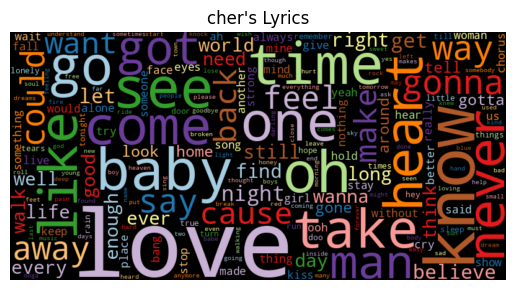


cher's Twitter Word Cloud:


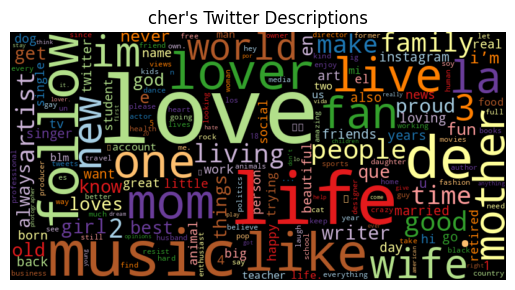




robyn's Lyrics Word Cloud:


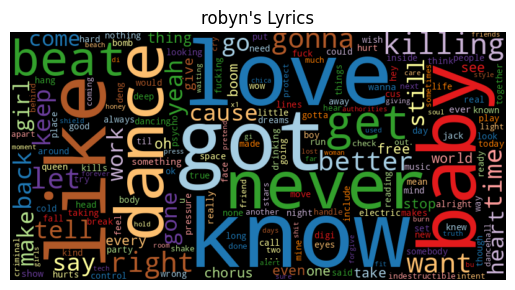


robyn's Twitter Word Cloud:


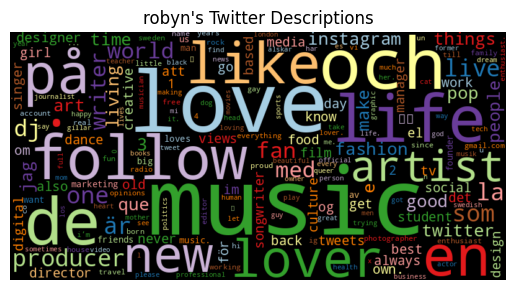

<Figure size 640x480 with 0 Axes>

In [29]:
# Generating word clouds for each artist
for artist in artist_folders:
    # Lyrics word cloud
    print(f"{artist}'s Lyrics Word Cloud:")
    lyrics_freq = count_words(artist_lyrics_dfs[artist], column='cleaned_lyrics')
    wordcloud(lyrics_freq['freq'], title=f"{artist}'s Lyrics", max_words=200)

    # Twitter description word cloud
    print(f"\n{artist}'s Twitter Word Cloud:")
    twitter_freq = count_words(artist_twitter_dfs[artist], column='cleaned_description')
    wordcloud(twitter_freq['freq'], title=f"{artist}'s Twitter Descriptions", max_words=200)
    print("\n\n")

Q: What observations do you have about these (relatively straightforward) wordclouds?

A: All four copra use love a lot. This can be seen in the lyrics and twitter engagement. This also follows the positive reception of the music created by the artists. Like is also seen frequently, but without context for the word 'like', it is hard to determine if it is actually imporant. It may need to be filtered out. Oddly, the lyrics wordclouds appear to associate with negative connotations such as killing and never, but these words do not appear in the twitter wordclouds. The twitter wordclouds appear to have more positive connotations.